In [1]:
import pyaudio
import math
import numpy as np

from lib.test import *

In [2]:
audioport = pyaudio.PyAudio()

In [3]:
framerate = 44100

In [4]:
latency = (262)/framerate

In [5]:
latency*1000

5.941043083900227

In [52]:
class Audio():
    def __init__(self, gen, amp=1, chunk=1024, latency=True):
        self.amp = amp
        self.latency = latency
        self.gen = gen
        self.stream = audioport.open(
            rate=framerate, 
            channels=1, 
            format=pyaudio.paFloat32, 
            frames_per_buffer=chunk,
            output=True, 
            stream_callback=self.get_frame)
        self.framebuf = np.empty(chunk, dtype=np.float32)
        self.when = []
    
    def get_frame(self, in_data, frame_count, time_info, status):
        
        for f in range(frame_count):
            if self.latency:
                # block until within latency
                while self.stream.get_time() < time_info['output_buffer_dac_time'] + f / framerate - latency:
                    pass
            self.framebuf[f] = self.gen()
            self.when.append(self.stream.get_time())
        return (self.framebuf.tobytes(), pyaudio.paContinue)

In [53]:
import torch.nn as nn
import torch

In [54]:
class Model(nn.Module):
    def __init__(self, width=4, layers=2):
        super().__init__()
        self.uniform = torch.distributions.uniform.Uniform(-1, 1)
        self.gru = nn.GRU(1, width, layers)
        self.state = None
        self.linear = nn.Linear(width, 1)
        self.tanh = nn.Tanh()
        
    def forward(self):
        output, self.state = self.gru(self.uniform.sample().reshape((1,1,1)), self.state)
        output = self.linear(output)
        output = self.tanh(output)
        return output.squeeze().detach().numpy()

In [58]:
from torch import Tensor

In [60]:
audio = Audio(Model())

In [61]:
audio.stream.stop_stream()

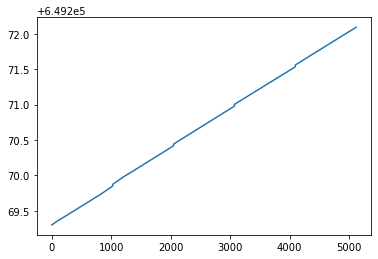

In [62]:
import matplotlib.pyplot as plt
plt.plot(audio.when)

In [63]:
latency = 8

In [64]:
audio = Audio(Model(), chunk=2048, latency=False)

In [65]:
audio.stream.stop_stream()

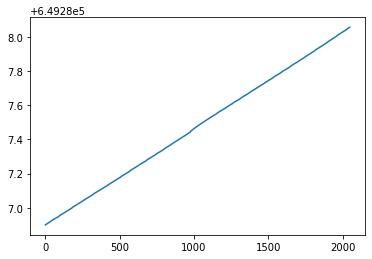

In [66]:
plt.plot(audio.when)

In [67]:
def plot_deltas(when):
    plt.plot([when[j+1] - when[j] for j in range(len(when) - 1)])

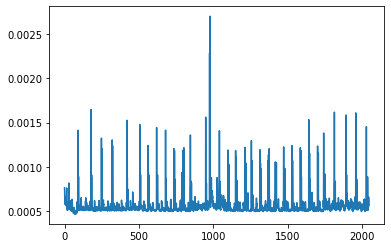

In [68]:
plot_deltas(audio.when)

In [69]:
audio = Audio(Model(width=2, layers=1), chunk=2048, latency=False)

In [70]:
audio.stream.stop_stream()

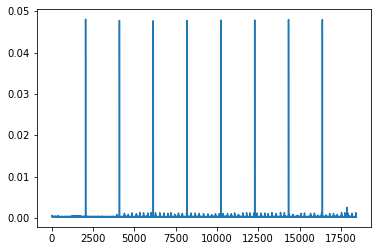

In [71]:
plot_deltas(audio.when)

In [75]:
import time

class FrameTiming():
    def __init__(self, gen):
        self.gen = gen
        
    def count(self):
        start = time.time()
        printed = 0
        frames = 0
        while True:
            try:
                self.gen()
                frames += 1
                now = time.time()
                if now > printed + 2:
                    print(f'{frames:06} frames in {now - start}.  {frames / (now - start)} fps')
                    printed = now
            except KeyboardInterrupt:
                break

In [76]:
timing = FrameTiming(Model())

In [77]:
timing.count()

000001 frames in 0.0036809444427490234.  271.66940864045597 fps
003595 frames in 2.0043959617614746.  1793.5577942597197 fps
007295 frames in 4.004608869552612.  1821.6510619712492 fps
010987 frames in 6.005107164382935.  1829.609314079408 fps
014645 frames in 8.005348920822144.  1829.4018343045525 fps
018143 frames in 10.005381107330322.  1813.3242307689559 fps
021514 frames in 12.005466938018799.  1792.0169295431292 fps
024971 frames in 14.00619888305664.  1782.8534499968814 fps
028299 frames in 16.006619930267334.  1767.9560159036878 fps
031481 frames in 18.0069317817688.  1748.2711869810648 fps
034033 frames in 20.00694489479065.  1701.0593161008512 fps
037419 frames in 22.007166147232056.  1700.309787714597 fps
040793 frames in 24.007829904556274.  1699.1539911009695 fps


In [78]:
timing = FrameTiming(Model(width=2, layers=1))

In [79]:
timing.count()

000001 frames in 0.0025739669799804688.  388.5053723601334 fps
004708 frames in 2.002761125564575.  2350.7546356397456 fps
009543 frames in 4.002860069274902.  2384.0453662744862 fps
014303 frames in 6.003193140029907.  2382.5653558647195 fps
019478 frames in 8.003421068191528.  2433.709264331046 fps
024735 frames in 10.003458023071289.  2472.6449536703103 fps
029946 frames in 12.00365400314331.  2494.7403509096694 fps
035173 frames in 14.003777980804443.  2511.679351687315 fps
040384 frames in 16.00407385826111.  2523.3575124470117 fps
045661 frames in 18.004110097885132.  2536.1431224175644 fps
050525 frames in 20.004117012023926.  2525.7300769452013 fps
054669 frames in 22.00417399406433.  2484.4831719085237 fps


In [81]:
timing = FrameTiming(Model(width=1, layers=1))
timing.count()

000001 frames in 0.00115203857421875.  868.0264900662252 fps
005006 frames in 2.0012762546539307.  2501.40378588845 fps
009719 frames in 4.001520156860352.  2428.826950512143 fps
014855 frames in 6.001540184020996.  2475.197956609738 fps
020134 frames in 8.001764059066772.  2516.1951603891935 fps
024751 frames in 10.002563238143921.  2474.465735504093 fps


In [82]:
timing = FrameTiming(Model(width=16, layers=1))
timing.count()

000001 frames in 0.001276254653930664.  783.5426863441061 fps
004543 frames in 2.0016911029815674.  2269.5809524422084 fps
009192 frames in 4.0020060539245605.  2296.848099713862 fps
013596 frames in 6.002065181732178.  2265.2203180632964 fps
018252 frames in 8.002357959747314.  2280.827737500552 fps
022968 frames in 10.003141164779663.  2296.078763825574 fps
028022 frames in 12.003353118896484.  2334.514341320667 fps
033153 frames in 14.003607988357544.  2367.4613019418325 fps
038327 frames in 16.00390124320984.  2394.853568361117 fps
042896 frames in 18.004374027252197.  2382.532152190949 fps
